# Impulse generator

> Generator for impulses of different shapes.

In [ ]:
# | default_exp solver.generator

In [ ]:
# | export

import numpy as np
from typing import Tuple, Optional

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# | export


class Generator:
    pass

In [ ]:
# | export


class Gaussian(Generator):
    def __init__(
        self,
        num_points: int = 100,
    ):
        self.x = np.linspace(0, 1, num_points)
        self.dx = self.x[1] - self.x[0]

    def __call__(
        self,
        mean: float = 0.5,  # in percentage w.r.t. the number of points
        std: float = 0.05,  # in percentage w.r.t. the number of points
    ):
        std_corr = np.max([std, self.dx])  # To avoid too narrow gaussians
        return np.exp(-(((self.x - mean) / std_corr) ** 2))

[<matplotlib.lines.Line2D>]

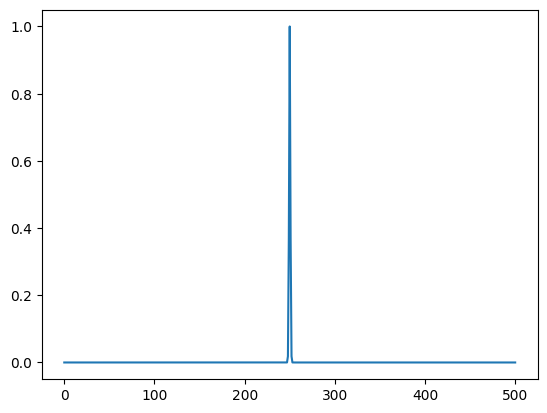

In [ ]:
# | test

y = Gaussian(num_points=501)(mean=0.5, std=0.0000005)
assert len(y) == 501
# plot the gaussian
plt.plot(y)

In [ ]:
# | export

class Gaussian2d(Generator):
    """This class generates a 2D gaussian distribution."""

    def __init__(
        self,
        num_points_x: int = 100,
        aspect_ratio: float = 1.0,  # aspect ratio of the lengths of the two axes, ly/lx
    ):
        self.aspect_ratio = aspect_ratio
        num_points_y = int(np.floor((num_points_x - 1) * aspect_ratio)) + 1
        x = np.linspace(0, 1, num_points_x)
        y = np.linspace(0, aspect_ratio, num_points_y)
        self.dx = x[1] - x[0]
        self.dy = y[1] - y[0]
        self.grid_x, self.grid_y = np.meshgrid(x, y, indexing="ij")

    def __call__(
        self,
        mean: tuple[float, float] = (0.5, 0.5),  # respect to the plate aspect ratio
        std: float = 0.05,  # in percentage w.r.t. the number of points
    ):
        std_corr = np.max([std, self.dx, self.dy])  # To avoid too narrow gaussians
        return np.exp(
            -(
                (self.grid_x - mean[0]) ** 2
                + (self.grid_y - self.aspect_ratio * mean[1]) ** 2
            )
            / (std**2)
        )

(101, 71)
101 71


<matplotlib.image.AxesImage>

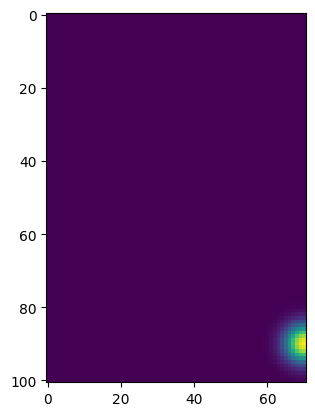

In [ ]:
# | test
nx = 101
aspect_ratio = 0.7
z = Gaussian2d(num_points_x=nx, aspect_ratio=aspect_ratio)(mean=(0.9,1.0), std=0.05)
ny = int(np.floor((nx -1) * aspect_ratio)) + 1
print(z.shape)
print(nx, ny)
assert z.shape == (nx, ny)
# plot the gaussian
plt.imshow(z, vmin=0, vmax=1)

In [ ]:
# | export


class NoiseBurst(Generator):
    def __init__(
        self,
        num_points: int = 100,
    ):
        self.num_points = num_points
        self.x = np.linspace(0, 1, num_points)
        self.gaussian = Gaussian(num_points)
        self.dx = self.x[1] - self.x[0]

    def __call__(
        self,
        rng: np.random.Generator,
        noise_range=[0, 1],
        burst_mean: float = 0.5,
        burst_std: float = 0.1,
    ):
        std_corr = np.max([burst_std, self.dx])  # To avoid too narrow gaussian envelope
        y = rng.uniform(*noise_range, self.num_points) * self.gaussian(
            burst_mean, burst_std
        )
        return y

In [ ]:
# | test

rng = np.random.default_rng(42)
y = NoiseBurst(num_points=500)(rng, noise_range=[0, 1], burst_mean=0.5, burst_std=0.05)
assert len(y) == 500

In [ ]:
# | export


class Noise(Generator):
    def __init__(
        self,
        num_points: int = 100,
    ):
        self.num_points = num_points
        self.x = np.linspace(0, 1, num_points)
        self.dx = self.x[1] - self.x[0]

    def __call__(
        self,
        rng: np.random.Generator,
        noise_range=[0, 1],
    ):
        y = rng.uniform(*noise_range, self.num_points)
        return y

In [ ]:
# | export

class Noise2d(Generator):
    def __init__(
        self,
        num_points_x: int = 100,
        aspect_ratio: float = 1.0,  # aspect ratio of the lengths of the two axes, ly/lx
    ):
        self.num_points_x = num_points_x
        num_points_y = int(np.floor((num_points_x - 1) * aspect_ratio)) + 1
        self.num_points_y = num_points_y
        self.dx = 1 / (num_points_x - 1)

    def __call__(
        self,
        rng: np.random.Generator,
        noise_range=[0, 1],
    ):
        z = rng.uniform(*noise_range, (self.num_points_x, self.num_points_y))
        return z

<matplotlib.image.AxesImage>

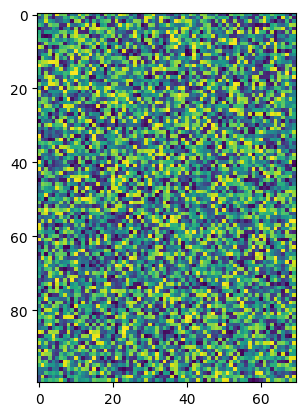

In [ ]:
# | test
rng = np.random.default_rng(42)
z = Noise2d(num_points_x=100, aspect_ratio=0.7)(rng, noise_range=[0, 1])
assert z.shape == (100, 70)
plt.imshow(z, vmin=0, vmax=1)


In [ ]:
# | export

class SineMode(Generator):
    def __init__(
        self,
        num_points: int = 100,
    ):
        self.x = np.linspace(0, 1, num_points)
        self.dx = self.x[1] - self.x[0]

    def __call__(
        self,
        k: int = 1,
    ):
        assert k > 0, "k must be positive"
        return np.sin(np.pi * k * self.x)

In [ ]:
# | export


# All these only applies for 1D


from typing import Type


def make_pluck_hammer(
    y: np.ndarray,
    ic_type: str = "pluck",  # "pluck" or "hammer"
) -> Tuple[np.ndarray, np.ndarray]:
    if ic_type == "pluck":
        return y, np.zeros_like(y)
    elif ic_type == "hammer":
        return np.zeros_like(y), y
    else:
        raise ValueError(f"ic_type should be either 'pluck' or 'hammer', got {ic_type}")


def generate_initial_condition(
    rng: np.random.Generator = np.random.default_rng(42),
    generator: Generator = Gaussian(),
    ic_type: str = "pluck",  # "pluck" or "hammer"
    ic_max_amplitude: float = 1.0,  # Amplitude of the initial condition, when ic_amplitude_random is True, this is the upper bound
    ic_min_amplitude: float = 0.0,  # only used when ic_amplitude_random is True
    ic_amplitude_random: bool = False,  # If True, the amplitude is chosen randomly between ic_min_amplitude and ic_max_amplitude
    ic_sine_k: int = 1,  # only used when ic_type is "sine"
) -> Tuple[np.ndarray, np.ndarray]:  # a tuple of position and velocity
    # Check that ic_max_amplitude is larger than ic_min_amplitude
    if ic_amplitude_random:
        assert ic_max_amplitude > ic_min_amplitude, (
            f"ic_max_amplitude should be larger than ic_min_amplitude, got "
            f"ic_max_amplitude={ic_max_amplitude} and ic_min_amplitude={ic_min_amplitude}"
        )
    # TODO: Mean and std are hard-coded, could be made more flexible
    mean = rng.uniform(0.3, 0.7)
    min_std = 2 * generator.dx
    std = rng.uniform(min_std, 0.1)
    if isinstance(generator, Gaussian):
        y = generator(mean, std)
    elif isinstance(generator, NoiseBurst):
        y = generator(rng, noise_range=[0, 1], burst_mean=mean, burst_std=std)
    elif isinstance(generator, Noise):
        y = generator(rng, noise_range=[0, 1])
    elif isinstance(generator, SineMode):
        y = generator(k=ic_sine_k)
    elif isinstance(generator, Gaussian2d):
        mean = (rng.uniform(0.3, 0.7), rng.uniform(0.3, 0.7))
        y = generator(mean, std)
    elif isinstance(generator, Noise2d):
        y = generator(rng, noise_range=[0, 1])
    else:
        raise TypeError(
            f"generator should be either Gaussian, Noise, Sine or NoiseBurst, got {type(generator)}"
        )
    # Normalize the amplitude to the desired value
    if ic_amplitude_random:
        amplitude = rng.uniform(ic_min_amplitude, ic_max_amplitude)
    else:
        amplitude = ic_max_amplitude

    y = y * amplitude / np.max(np.abs(y))
    return make_pluck_hammer(y, ic_type)

[<matplotlib.lines.Line2D>]

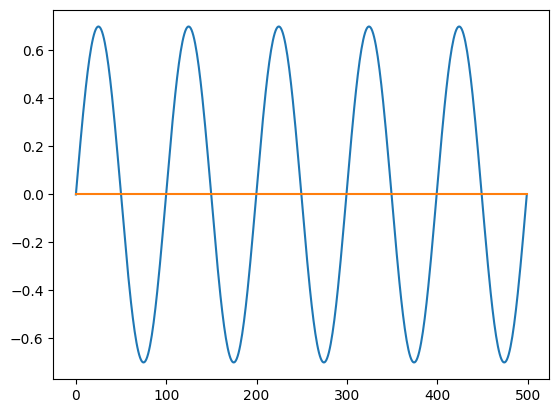

In [ ]:
# | test

rng = np.random.default_rng()
ic_type = "pluck"
ic_max_amplitude = 0.7
ic_min_amplitude = 0.1
ic_amplitude_random = False
num_points = 500
u, v = generate_initial_condition(
    rng,
    SineMode(num_points=num_points),
    ic_type=ic_type,
    ic_max_amplitude=ic_max_amplitude,
    ic_min_amplitude=ic_min_amplitude,
    ic_amplitude_random=ic_amplitude_random,
    ic_sine_k=10,
)
if ic_type == "pluck":
    assert np.all(v == 0)
    if ic_amplitude_random:
        assert np.max(np.abs(u)) <= ic_max_amplitude
        assert np.max(np.abs(u)) >= ic_min_amplitude
    else:
        assert np.max(np.abs(u)) == ic_max_amplitude
elif ic_type == "hammer":
    assert np.all(u == 0)
    if ic_amplitude_random:
        assert np.max(np.abs(v)) <= ic_max_amplitude
        assert np.max(np.abs(v)) >= ic_min_amplitude
    else:
        assert np.max(np.abs(v)) == ic_max_amplitude

# Plot the initial conditions
fig, ax = plt.subplots()
ax.plot(u)
ax.plot(v)

<matplotlib.image.AxesImage>

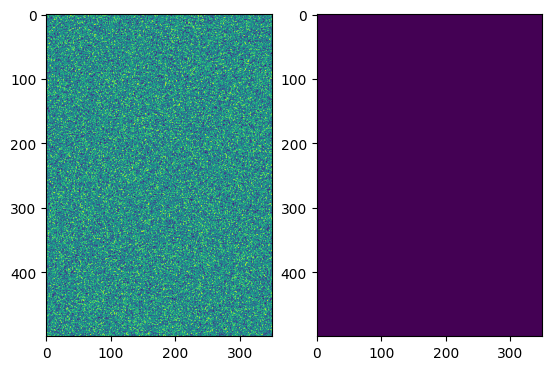

In [ ]:
# | test

# Test the 2d functions

rng = np.random.default_rng()
ic_type = "pluck"
ic_max_amplitude = 0.7
ic_min_amplitude = 0.1
ic_amplitude_random = False
num_points = 500
u, v = generate_initial_condition(
    rng,
    Noise2d(num_points_x=num_points, aspect_ratio=0.7),
    ic_type=ic_type,
    ic_max_amplitude=ic_max_amplitude,
    ic_min_amplitude=ic_min_amplitude,
    ic_amplitude_random=ic_amplitude_random,
)
if ic_type == "pluck":
    assert np.all(v == 0)
    if ic_amplitude_random:
        assert np.max(np.abs(u)) <= ic_max_amplitude
        assert np.max(np.abs(u)) >= ic_min_amplitude
    else:
        assert np.allclose(np.max(np.abs(u)), ic_max_amplitude)
elif ic_type == "hammer":
    assert np.all(u == 0)
    if ic_amplitude_random:
        assert np.max(np.abs(v)) <= ic_max_amplitude
        assert np.max(np.abs(v)) >= ic_min_amplitude
    else:
        assert np.allclose(np.max(np.abs(v)), ic_max_amplitude)

# Plot the initial conditions
fig, ax = plt.subplots(1,2)
ax[0].imshow(u)
ax[1].imshow(v)

In [ ]:
print(np.max(np.abs(u)))

0.7


In [ ]:
# | export
def raised_cosine_string(
    excitation_type: str = "pluck",
    c0: float = 0.5,  # peak amplitude in newtons
    x_0: float = 0.1,  # center of the excitation in meters
    width: float = 0.1,  # width of the excitation in meters
    length: float = 1.0,  # total length of the string in meters
    grid_points: int = 101,  # number of points along the string
):
    x = np.linspace(0, length, grid_points)
    excitation = np.zeros_like(x)

    for i, xi in enumerate(x):
        if abs(xi - x_0) <= width:
            excitation[i] = c0 * 0.5 * (1 + np.cos(np.pi * (xi - x_0) / width))
        else:
            excitation[i] = 0

    return excitation


def raised_cosine_2d(
    grid_x,  # number of points along the x direction
    grid_y,  # number of points along the y direction
    c0: float = 0.5,  # peak amplitude in newtons
    x_0: float = 0.1,  # center of the excitation in x direction
    y_0: float = 0.1,  # center of the excitation in y direction
    width: float = 0.1,  # width of the excitation in meters
    excitation_type: str = "pluck",
):
    distance = np.sqrt((grid_x - x_0) ** 2 + (grid_y - y_0) ** 2)
    excitation = np.where(
        distance <= width, c0 * 0.5 * (1 + np.cos(np.pi * distance / width)), 0
    )

    return excitation

[<matplotlib.lines.Line2D>]

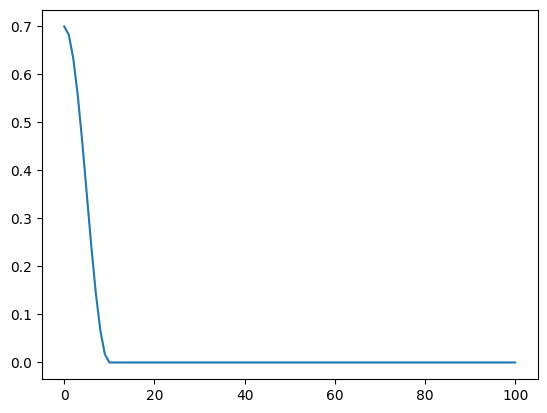

In [ ]:
exc = raised_cosine_string(
    excitation_type="pluck",
    c0=0.7,
    x_0=0,
    width=0.1,
    length=1.0,
    grid_points=101,
)

plt.plot(exc)

In [ ]:
def ricker(dt, pt):
    nt = int(2 * pt / dt)
    c = np.zeros(nt)
    t0 = pt / dt
    a_ricker = 4 / pt

    for it in range(0, nt):
        t = ((it + 1) - t0) * dt
        c[it] = -2 * a_ricker * t * np.exp(-(a_ricker * t) ** 2)

    return c


[<matplotlib.lines.Line2D>]

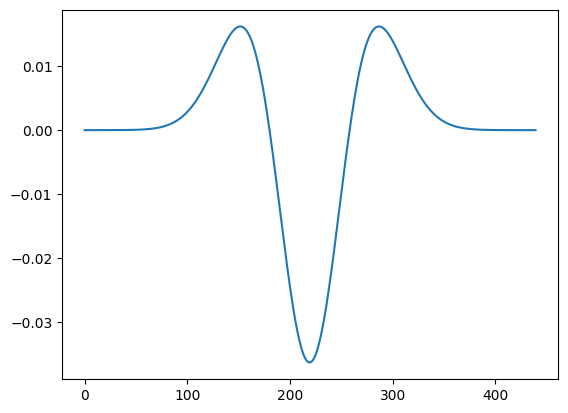

In [ ]:
dt = 1/44100
T0 = 1/200
tmp = ricker(dt, T0)
tmp = np.diff(tmp)

plt.plot(tmp)


In [ ]:
def gaus2d(
    x: np.ndarray,
    y: np.ndarray,
    A: float = 1, # amplitude
    mx: float = 0, # center x
    my: float = 0, # center y
    sx: float = 1, # sigma x (width in x direction)
    sy: float = 1, # sigma y (width in y direction)
):

    # norm = 1.0 / (2.0 * np.pi * sx * sy)
    gaussian = np.exp(
        -((x - mx) ** 2.0 / (2.0 * sx**2.0) + (y - my) ** 2.0 / (2.0 * sy**2.0))
    )
    return A * gaussian

y = np.linspace(0, 50)
x = np.linspace(0, 50)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
z = gaus2d(x, y, 2, 5, 5)

print(z.max())

1.9792833848731148


In [ ]:
# | export
def create_pluck_modal(
    wavenumbers: np.ndarray,
    xe: float = 0.28,  # pluck position in m
    hi: float = 0.03,  # initial deflection in m
    length: float = 1.0,  # length of the string in m
) -> np.ndarray:
    """
    Create a pluck excitation for a string with a given length and pluck position.
    The pluck is modeled in the modal domain. This function is based on the function https://github.com/julian-parker/DAFX22_FNO.

    Parameters
    ----------
    wavenumbers : np.ndarray
        The wavenumbers of the modes.
    xe : float
        The position of the pluck in meters.
    hi : float
        The initial deflection of the string in meters.
    length : float
        The length of the string in meters.

    Returns
    -------
    np.ndarray
        The pluck excitation in the modal domain.
    """

    return (
        hi
        * (length / (length - xe) * np.sin(wavenumbers * xe) / (wavenumbers * xe))
        / wavenumbers
    )